In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (8,5)


In [14]:
fear_greed = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Fear/Greed Dataset Shape:", fear_greed.shape)
print("Trades Dataset Shape:", trades.shape)

fear_greed.head()


Fear/Greed Dataset Shape: (2644, 4)
Trades Dataset Shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [15]:
print("Fear/Greed Missing Values:")
print(fear_greed.isnull().sum())

print("\nTrades Missing Values:")
print(trades.isnull().sum())

print("\nFear/Greed Date Range:")
print(fear_greed['date'].min(), "to", fear_greed['date'].max())


Fear/Greed Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Fear/Greed Date Range:
2018-02-01 to 2025-05-02


In [16]:
fear_greed['date'] = pd.to_datetime(fear_greed['date'], errors='coerce')
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True, errors='coerce')

fear_greed['Date'] = fear_greed['date'].dt.date
trades['Date'] = trades['Timestamp IST'].dt.date

fear_greed.dropna(subset=['Date'], inplace=True)
trades.dropna(subset=['Date'], inplace=True)

merged = trades.merge(
    fear_greed[['Date', 'classification']],
    on='Date',
    how='inner'
)

merged.rename(columns={
    'Account': 'account',
    'Closed PnL': 'closedPnL',
    'Side': 'side'
}, inplace=True)

print("Merged Dataset Shape:", merged.shape)
merged.head()


Merged Dataset Shape: (211218, 18)


,account,Coin,Execution Price,Size Tokens,Size USD,side,Timestamp IST,Start Position,Direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


In [23]:
merged['win'] = (merged['closedPnL'] > 0).astype(int)

daily_pnl = merged.groupby(['Date', 'account'])['closedPnL'].sum().reset_index()

win_rate = merged.groupby('account')['win'].mean().reset_index()

trade_count = merged.groupby('account').size().reset_index(name='trade_count')

long_short = merged.groupby(['classification', 'side']).size().unstack(fill_value=0)

print("Long/Short Table:")
long_short


Long/Short Table:


side,BUY,SELL
classification,,
Extreme Fear,10935,10465
Extreme Greed,17940,22052
Fear,30270,31567
Greed,24576,25727
Neutral,18969,18717


In [18]:
sentiment_pnl = merged.groupby('classification')['closedPnL'].mean()
sentiment_win = merged.groupby('classification')['win'].mean()
sentiment_freq = merged.groupby('classification').size()

print("Average PnL by Sentiment:\n", sentiment_pnl)
print("\nWin Rate by Sentiment:\n", sentiment_win)


Average PnL by Sentiment:
 classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: closedPnL, dtype: float64

Win Rate by Sentiment:
 classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64


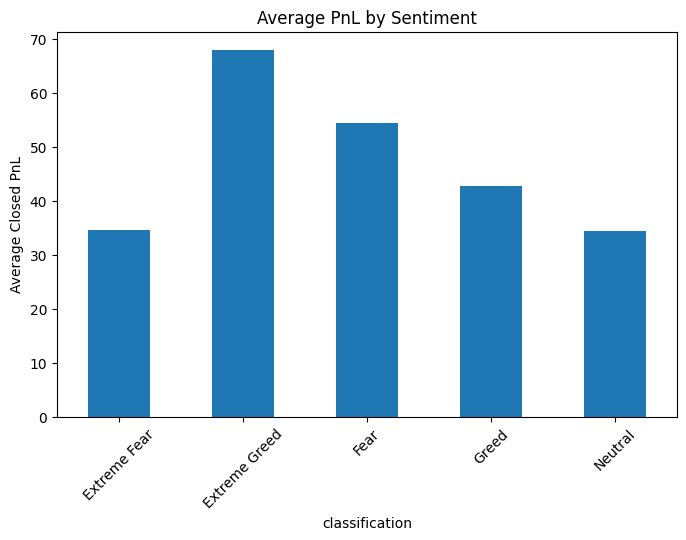

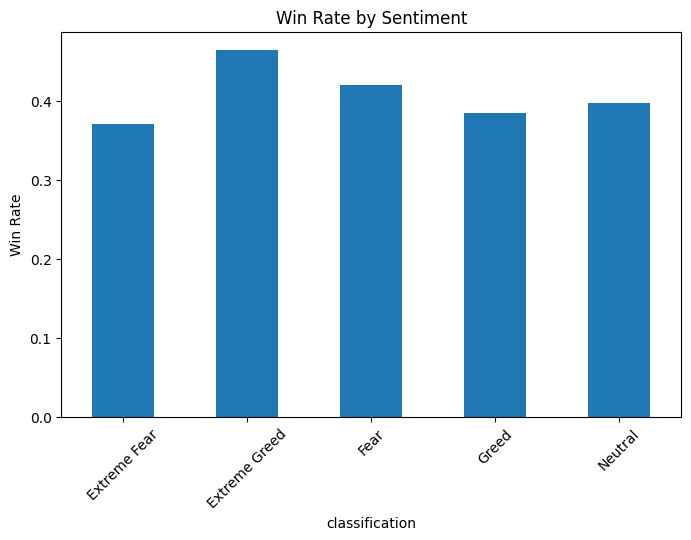

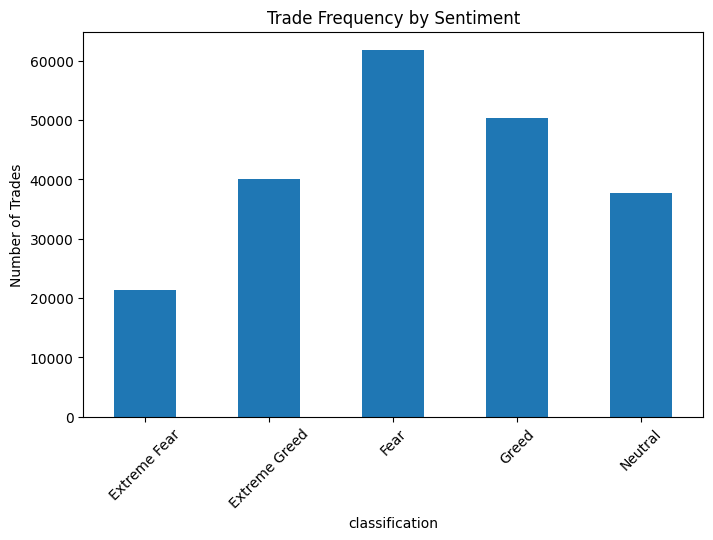

In [ ]:
sentiment_pnl.plot(kind='bar')
plt.title("Average PnL by Sentiment")
plt.ylabel("Average Closed PnL")
plt.xticks(rotation=45)
plt.show()

sentiment_win.plot(kind='bar')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()

sentiment_freq.plot(kind='bar')
plt.title("Trade Frequency by Sentiment")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.show()


In [ ]:
trader_features = merged.groupby('account').agg({
    'closedPnL': 'sum',
    'win': 'mean',
    'account': 'count'
}).rename(columns={'account':'trade_count'}).reset_index()

scaler = StandardScaler()
scaled = scaler.fit_transform(
    trader_features[['closedPnL', 'win', 'trade_count']]
)

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled)

trader_features.head()


,account,closedPnL,win,trade_count,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,0.359612,3818,0
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,0.442720,7280,2
2,0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,0.301917,3809,2
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,0.438585,13311,1
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,0.519914,3239,0


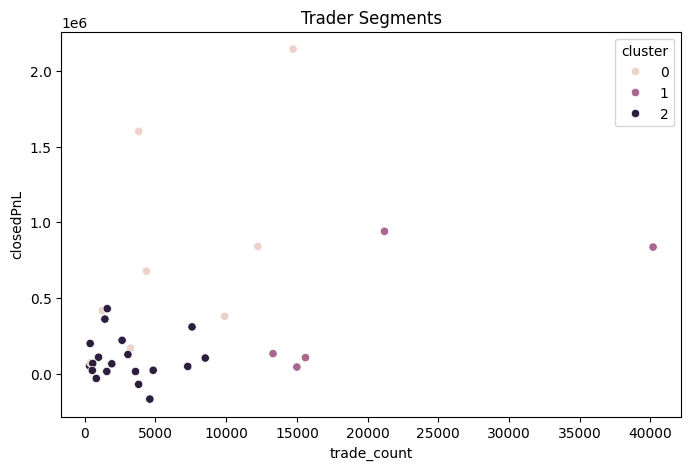

In [21]:
sns.scatterplot(
    data=trader_features,
    x='trade_count',
    y='closedPnL',
    hue='cluster'
)
plt.title("Trader Segments")
plt.show()


In [24]:
encoded = pd.get_dummies(merged, columns=['classification'], drop_first=True)

y = encoded['win']

X = encoded.select_dtypes(include=['int64', 'float64'])

X = X.drop(columns=['win'], errors='ignore')

print("Final Feature Columns:")
print(X.columns)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=500,
    solver='liblinear'
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, pred))

print("\nClassification Report:")
print(classification_report(y_test, pred))


Final Feature Columns:
Index(['Execution Price', 'Size Tokens', 'Size USD', 'Start Position',
       'closedPnL', 'Order ID', 'Fee', 'Trade ID', 'Timestamp'],
      dtype='object')
Confusion Matrix:
[[24848     0]
 [17396     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74     24848
           1       0.00      0.00      0.00     17396

    accuracy                           0.59     42244
   macro avg       0.29      0.50      0.37     42244
weighted avg       0.35      0.59      0.44     42244



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha